# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic

# Data Generation

In [2]:
#Create empty graph
G = nx.Graph()

In [3]:
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

G.add_edges_from([
    (0,1),
    (1,2),
    (2,3),
    (3,4),
    (4,5),
    (5,6),
    (6,7),
    (7,8),
    (8,9),
    (9,0),

    (0,2),
    (0,3),
    (0,4),
    (1,3)
])

In [4]:
G = nx.Graph()

In [5]:
G = misc.createRandomGraph(size=30, density=0.4, maxDegree=1000)
misc.graphInfo(G)

Chosen max degree does not fall into range (22, 38) permitted by other parameters, so picking closest value instead
Nodes: 39
Edges: 427
Density: 0.5762483130904184
Max Degree: 38
Average Degree: 21.897435897435898
Static Coloring uses 11 colors


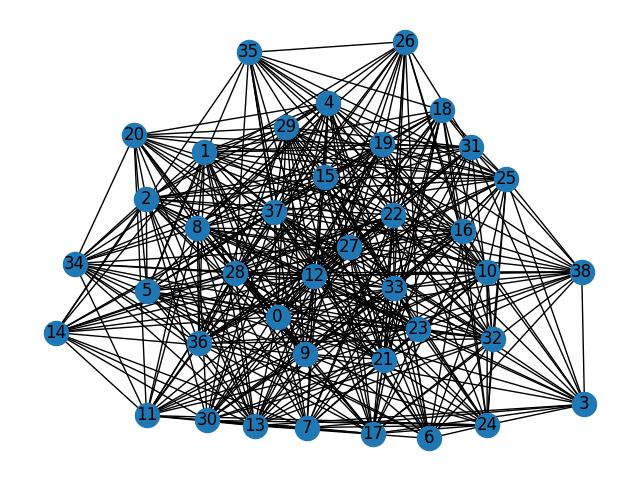

In [6]:
misc.draw(G)

# Common items

In [7]:
from queue import PriorityQueue


In [8]:
def nodePriority(node):
    return (-1*Gstar.degree(node), list(Gstar.nodes()).index(node))

In [9]:
# Returns wheter a comes before b in the ordering of nodes
def isBefore(a, b):
    if nodePriority(a) < nodePriority(b):
        return True
    else:
        return False

In [10]:
class DincIndex:
    def __init__(self):
        self.cnt = {}
        self.cu = set({})

In [11]:
Gstar = nx.DiGraph()

Gstar.add_nodes_from(G.nodes())
nx.set_node_attributes(Gstar, 0, 'color')                 # Reset all colors to 0
for node in Gstar.nodes():
    Gstar.nodes[node]['DINC'] = DincIndex()               # Initialize all DINC indices
G = nx.Graph()
G.add_nodes_from(Gstar.nodes())
G.add_edges_from(Gstar.edges())

for edge in G.edges():
    if isBefore(edge[0], edge[1]):
        Gstar.add_edge(edge[0], edge[1])
    else:
        Gstar.add_edge(edge[1], edge[0])

In [12]:
def collectColor(u):
    C = set({})
    for edge in Gstar.in_edges(u):
        v = edge[0]
        C.add(Gstar.nodes[v]['color'])
    return C

In [13]:
def assignColor(u, C):
    colorNew = None
    for i in range(0, Gstar.degree(u) + 1):
        if i not in C:
            colorNew = i
            break
    if Gstar.nodes[u]['color'] != colorNew:
        Gstar.nodes[u]['color'] = colorNew
        return True
    else:
        return False

In [14]:
def notifyColor(u, b: bool, q: PriorityQueue):
    if b:
        for edge in Gstar.out_edges(u):
            v = edge[1]
            if not nodePriority(v) in q.queue:
                q.put((nodePriority(v), v))

In [15]:
def CAN(q: PriorityQueue):
    while not q.empty():
        u = q.get()[1]
        C = collectColor(u)
        b = assignColor(u, C)
        notifyColor(u, b, q)

In [16]:
def dincColorIncrease(u, v):
    I = Gstar.nodes[u]['DINC']
    c = Gstar.nodes[v]['color']
    if c <= Gstar.in_degree(u):
        if I.cnt.get(c, 0) != 0:
            I.cnt[c] += 1
        else:
            I.cnt[c] = 1
    if c in I.cu:
        I.cu.remove(c)

In [17]:
def dincColorDecrease(u, v):
    I = Gstar.nodes[u]['DINC']
    c = Gstar.nodes[v]['color']
    if c <= Gstar.in_degree(u):
        if I.cnt.get(c, 1) != 1:
            I.cnt[c] += -1
        else:
            I.cnt.pop(c)
    if I.cnt.get(c, 0) == 0 and c < Gstar.nodes[u]['color']:
        I.cu.add(c)

In [18]:
def ocgInsert(u, v):
    S = set({})
    S.add(u)
    S.add(v)

    Gstar.add_edge(u, v)

    for edge in list(Gstar.in_edges(u)).copy():
        nbr = edge[0]
        if isBefore(u, nbr):
            Gstar.remove_edge(nbr, u)
            Gstar.add_edge(u, nbr)
            dincColorIncrease(nbr, u)
            dincColorDecrease(u, nbr)
            S.add(nbr)
    
    for edge in list(Gstar.in_edges(v)).copy():
        nbr = edge[0]
        if isBefore(v, nbr):
            Gstar.remove_edge(nbr, v)
            Gstar.add_edge(v, nbr)
            dincColorIncrease(nbr, v)
            dincColorDecrease(v, nbr)
            S.add(nbr)
    dincColorIncrease(v, u)
    for edge in Gstar.in_edges(v):
        nbr = edge[0]
        if Gstar.nodes[nbr]['color'] == Gstar.in_degree(v):
            dincColorIncrease(v, nbr)
    return S

In [50]:
def ocgDelete(u, v):
    S = set({})
    S.add(u)
    S.add(v)

    if not Gstar.has_edge(u, v):
        # If this edge is not in Gstar it must be present in the opposite direction
        x = u
        u = v
        v = x
    Gstar.remove_edge(u, v)

    for edge in list(Gstar.out_edges(u)).copy():
        nbr = edge[1]
        if isBefore(nbr, u):
            Gstar.remove_edge(u, nbr)
            Gstar.add_edge(nbr, u)
            dincColorIncrease(u, nbr)
            dincColorDecrease(nbr, u)
            S.add(nbr)
    
    for edge in list(Gstar.out_edges(v)).copy():
        nbr = edge[1]
        if isBefore(nbr, v):
            Gstar.remove_edge(v, nbr)
            Gstar.add_edge(nbr, v)
            dincColorIncrease(v, nbr)
            dincColorDecrease(nbr, v)
            S.add(nbr)
    dincColorDecrease(v, u)
    if Gstar.in_degree(v) + 1 in Gstar.nodes[v]['DINC'].cnt:
        Gstar.nodes[v]['DINC'].cnt.pop(Gstar.in_degree(v) + 1)
    return S

In [20]:
def dcOrientInsert(u, v):
    q = PriorityQueue()
    S = ocgInsert(u, v)
    for w in S:
        q.put((nodePriority(w), w))
    CAN(q)

In [21]:
def dcOrientDelete(u, v):
    q = PriorityQueue()
    S = ocgDelete(u, v)
    for w in S:
        q.put((nodePriority(w), w))
    CAN(q)

In [22]:
# Returns a coloring dictionary from the nodes 'color' attributes
def getColoring() -> dict:
    coloring: dict = {}
    for node in Gstar.nodes():
        coloring[node] = Gstar.nodes[node]['color']
    return coloring

In [23]:
# Print the current situation of the leveled segment data structure
def printLevels():
    print("l: " + str(l))
    print("c: " + str(c))

# Algorithm Specific Methods

In [24]:
def removeEdge(s, t):
    if not G.has_edge(s, t):    # Potentially redundant
        print("Edge not present in graph")
        return
    G.remove_edge(s, t)
    dcOrientDelete(s, t)

def removeVertex(v):

    if not G.has_node(v):   # Potentially redundant
        print("Node not present in graph")
        return
    G.remove_node(v)
    Gstar.remove_node(v)

def addEdge(s, t):

    if G.has_edge(s, t):    # Potentially redundant, but could be extended to also check if the vertices are present yet
        print("Edge already in the graph")
        return
    if (not G.has_node(s) or not G.has_node(t)):
        print("Not all nodes present in graph yet")
        return
    G.add_edge(s, t)
    dcOrientInsert(s,t)

def addVertex(v):
    if G.has_node(v):   # Potentially redundant, depending on the input used during the experiments
        print("Node already present in graph")
        return
    G.add_node(v)
    Gstar.add_node(v)
    Gstar.nodes[v]['color'] = 0
    Gstar.nodes[v]['DINC'] = DincIndex()

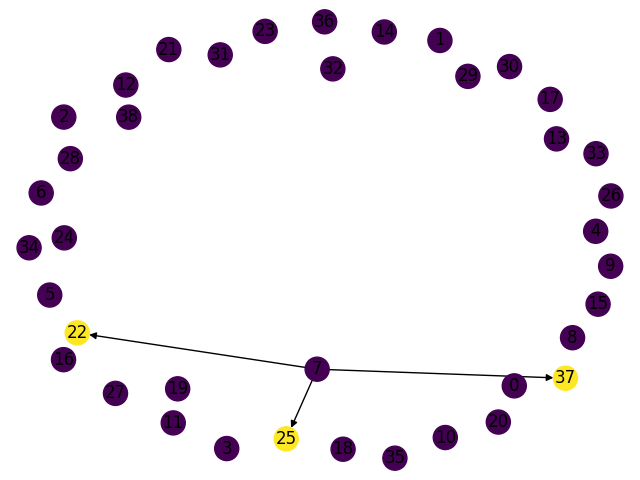

In [53]:
removeEdge(25,37)
misc.draw(Gstar, getColoring())

In [56]:
Gstar.nodes[25]['DINC'].cnt

{0: 1}

In [27]:
getColoring()

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 1,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0}

In [28]:
sda = StaticDynamic.StaticDynamicAlgo(G)

In [29]:
c1 = sda.getColoring()

sda.removeVertex(7)

c2 = sda.getColoring()
misc.numberOfRecolors(c1, c2)

0

In [30]:
sda.getColoring()

{0: ('L0C0', 0),
 1: ('L0C0', 0),
 2: ('L0C0', 0),
 3: ('L0C0', 0),
 4: ('L0C0', 0),
 5: ('L0C0', 0),
 6: ('L0C0', 0),
 8: ('L0C0', 0),
 9: ('L0C0', 0),
 10: ('L0C0', 0),
 11: ('L0C0', 0),
 12: ('L0C0', 0),
 13: ('L0C0', 0),
 14: ('L0C0', 0),
 15: ('L0C0', 0),
 16: ('L0C0', 0),
 17: ('L0C0', 0),
 18: ('L0C0', 0),
 19: ('L0C0', 0),
 20: ('L0C0', 0),
 21: ('L0C0', 0),
 22: ('L0C1', 0),
 23: ('L0C0', 0),
 24: ('L0C0', 0),
 25: ('L0C0', 0),
 26: ('L0C0', 0),
 27: ('L0C0', 0),
 28: ('L0C0', 0),
 29: ('L0C0', 0),
 30: ('L0C0', 0),
 31: ('L0C0', 0),
 32: ('L0C0', 0),
 33: ('L0C0', 0),
 34: ('L0C0', 0),
 35: ('L0C0', 0),
 36: ('L0C0', 0),
 37: ('L0C0', 0),
 38: ('L0C0', 0)}

In [31]:
sda.printLevels()

l: 5
c: 0
Last Updated Level: 0
Max Level: 5


In [32]:
misc.verifyColoring(sda.G, sda.getColoring())

True

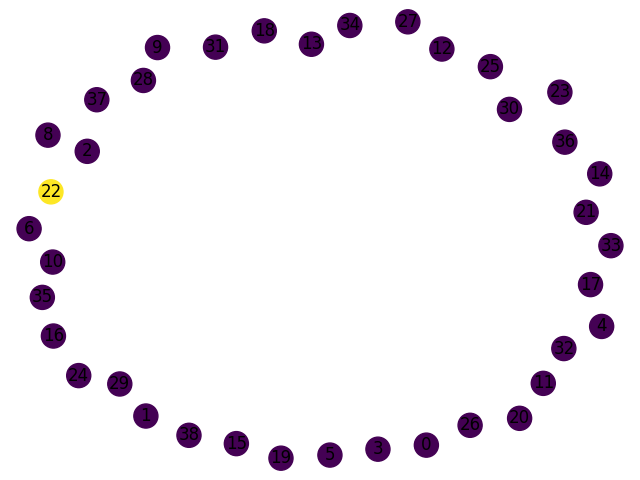

In [33]:
misc.draw(sda.G, sda.getColoring())

In [34]:
misc.numberOfColors(sda.getColoring())

2

In [35]:
Ge = nx.Graph()
Ge.add_nodes_from(G.nodes())
edges = list(G.edges())

In [36]:
misc.extractUpdates(G, 'skewed')

[(7, 22)]

In [37]:
wu2 = RandomWarmUp2.WarmUp2Algo(Ge, misc.getMaxDegree(G))

updi = misc.UpdateIterator(wu2, edges)

No more updates in given update sequence
True


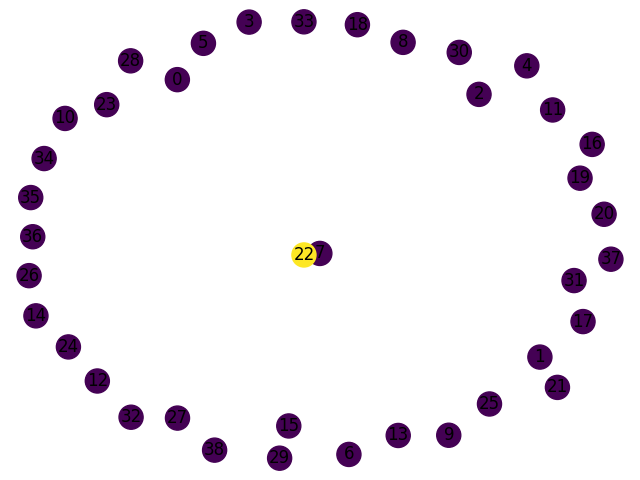

In [38]:
updi.runUpdate(10)
print(misc.verifyColoring(wu2.G, wu2.getColoring()))
misc.draw(wu2.G, wu2.getColoring())

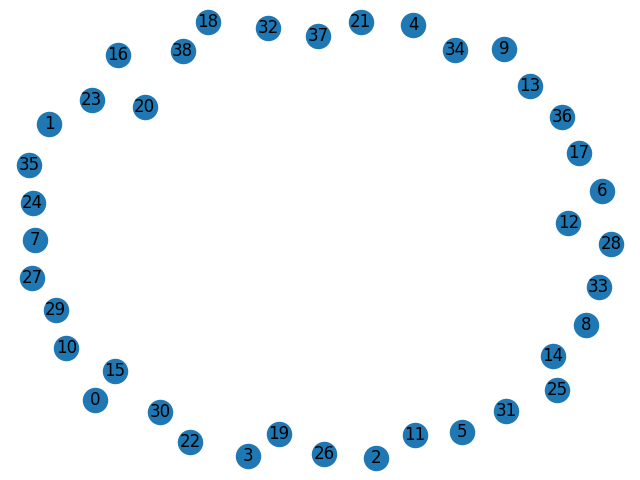

In [39]:
misc.draw(Ge)